#Import Libraries and prepare dataset

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # plotting
import seaborn as sns # more plotting
import xgboost as xgb # common ML model
from sklearn.model_selection import train_test_split # ML utilities
from sklearn.linear_model import LogisticRegression # another common ML model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score# more ML utilities
from sklearn.decomposition import PCA
from sklearn import metrics  # Import metrics module for accuracy_score
import seaborn as sns # more plotting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/compas-scores-two-years.csv'

In [ ]:
data = pd.read_csv(file_path, usecols= ['sex', 'age', 'age_cat', 'race','juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'decile_score', 'is_recid'])

In [ ]:
print(data.columns)
len(data.columns)

Index(['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count', 'is_recid'],
      dtype='object')


10

In [ ]:
data

,sex,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,is_recid
0,Male,69,Greater than 45,Other,0,1,0,0,0,0
1,Male,34,25 - 45,African-American,0,3,0,0,0,1
2,Male,24,Less than 25,African-American,0,4,0,1,4,1
3,Male,23,Less than 25,African-American,0,8,1,0,1,0
4,Male,43,25 - 45,Other,0,1,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...
7209,Male,23,Less than 25,African-American,0,7,0,0,0,0
7210,Male,23,Less than 25,African-American,0,3,0,0,0,0
7211,Male,57,Greater than 45,Other,0,1,0,0,0,0
7212,Female,33,25 - 45,African-American,0,2,0,0,3,0


#Visualization of data

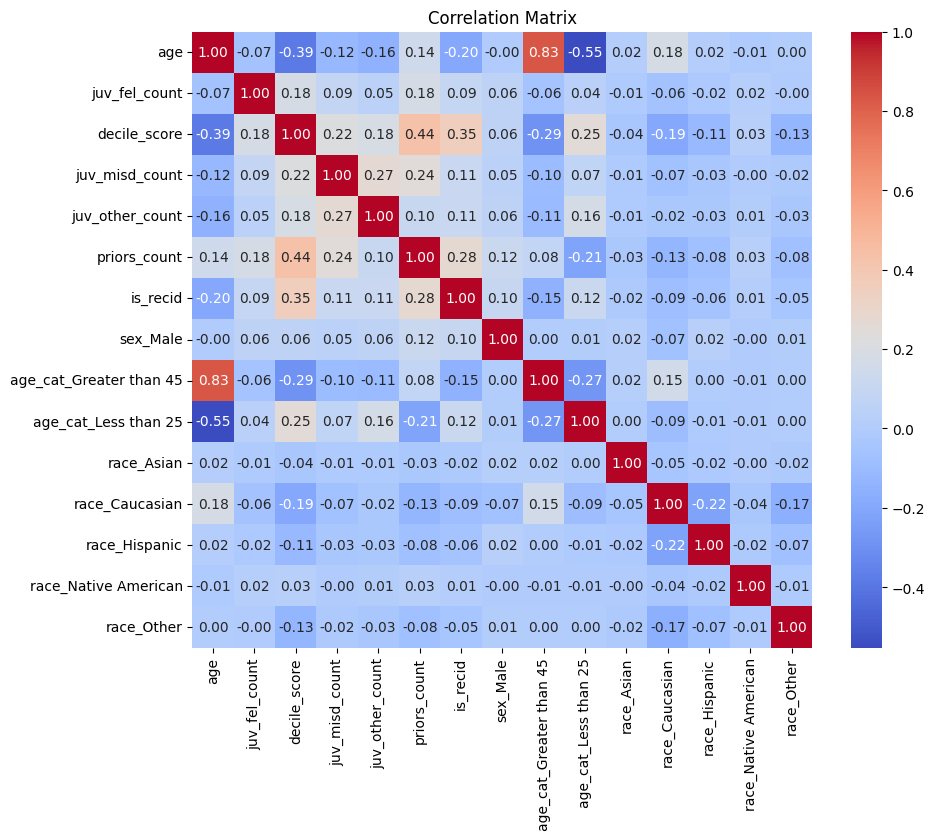

In [ ]:
categorical_columns = ['sex', 'age_cat', 'race']

df_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True) #one hot encoding for categorical data to help in visualizing correlation matrix
correlation_matrix = df_encoded.corr()

#correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

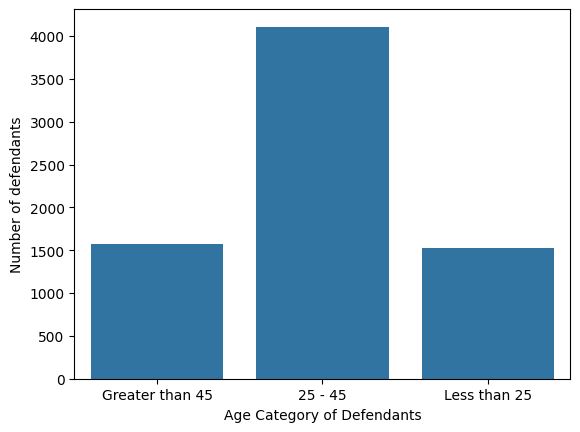

In [ ]:
sns.countplot(data=data, x="age_cat")
plt.ylabel("Number of defendants")
plt.xlabel("Age Category of Defendants")
plt.show()

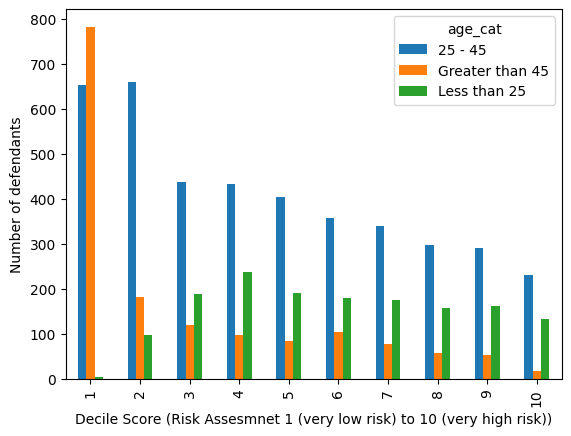

In [ ]:
pd.crosstab(data["decile_score"], data["age_cat"]).plot.bar()
plt.xlabel("Decile Score (Risk Assesmnet 1 (very low risk) to 10 (very high risk))")
plt.ylabel("Number of defendants")
plt.show()

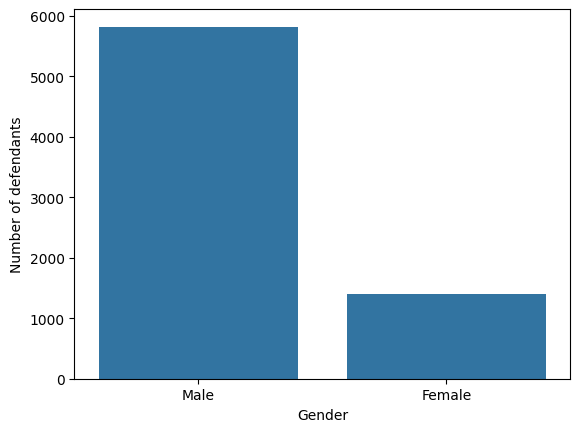

In [ ]:
sns.countplot(data=data, x="sex")
plt.xlabel("Gender")
plt.ylabel("Number of defendants")
plt.show()

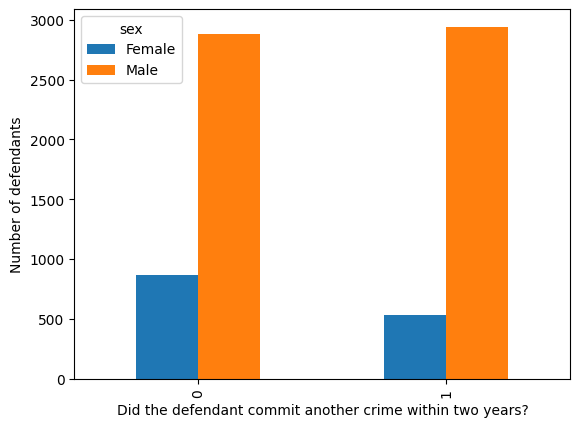

In [ ]:
pd.crosstab(data["is_recid"], data["sex"]).plot.bar()
plt.xlabel("Did the defendant commit another crime within two years?")
plt.ylabel("Number of defendants")
plt.show()

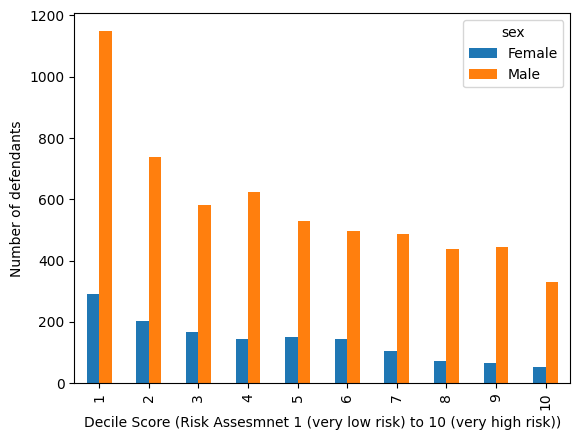

In [ ]:
pd.crosstab(data["decile_score"], data["sex"]).plot.bar()
plt.xlabel("Decile Score (Risk Assesmnet 1 (very low risk) to 10 (very high risk))")
plt.ylabel("Number of defendants")
plt.show()

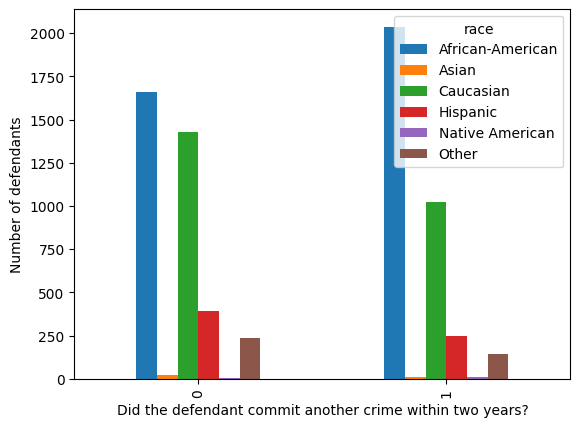

In [ ]:
pd.crosstab(data["is_recid"], data["race"]).plot.bar()
plt.xlabel("Did the defendant commit another crime within two years?")
plt.ylabel("Number of defendants")
plt.show()

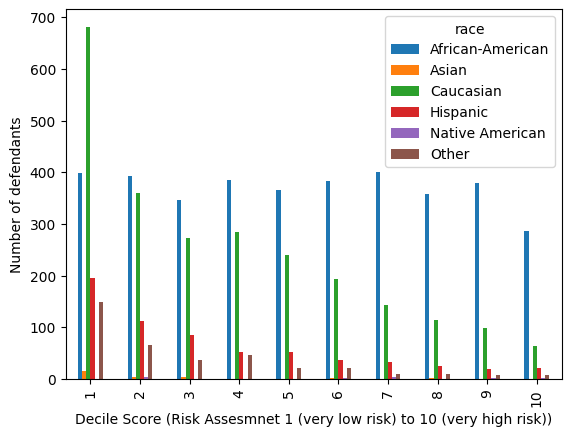

In [ ]:
pd.crosstab(data["decile_score"], data["race"]).plot.bar()
plt.xlabel("Decile Score (Risk Assesmnet 1 (very low risk) to 10 (very high risk))")
plt.ylabel("Number of defendants")
plt.show()

#Predictions based on recorded recidivism

In [ ]:
ml_data = data.copy()
ml_data.head()

,sex,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,is_recid
0,Male,69,Greater than 45,Other,0,1,0,0,0,0
1,Male,34,25 - 45,African-American,0,3,0,0,0,1
2,Male,24,Less than 25,African-American,0,4,0,1,4,1
3,Male,23,Less than 25,African-American,0,8,1,0,1,0
4,Male,43,25 - 45,Other,0,1,0,0,2,0


In [ ]:
cat_df = pd.get_dummies(ml_data.select_dtypes("object"), drop_first=False) # This step is done to convert categorical data into a format that machine learning models can understand and process effectively, avoiding issues related to implicit ordering and ensuring compatibility with various algorithms.
num_df = ml_data.select_dtypes(exclude="object")
ml_data = pd.concat([cat_df,num_df], axis=1)
ml_data.head()

,sex_Female,sex_Male,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,is_recid
0,False,True,False,True,False,False,False,False,False,False,True,69,0,1,0,0,0,0
1,False,True,True,False,False,True,False,False,False,False,False,34,0,3,0,0,0,1
2,False,True,False,False,True,True,False,False,False,False,False,24,0,4,0,1,4,1
3,False,True,False,False,True,True,False,False,False,False,False,23,0,8,1,0,1,0
4,False,True,True,False,False,False,False,False,False,False,True,43,0,1,0,0,2,0


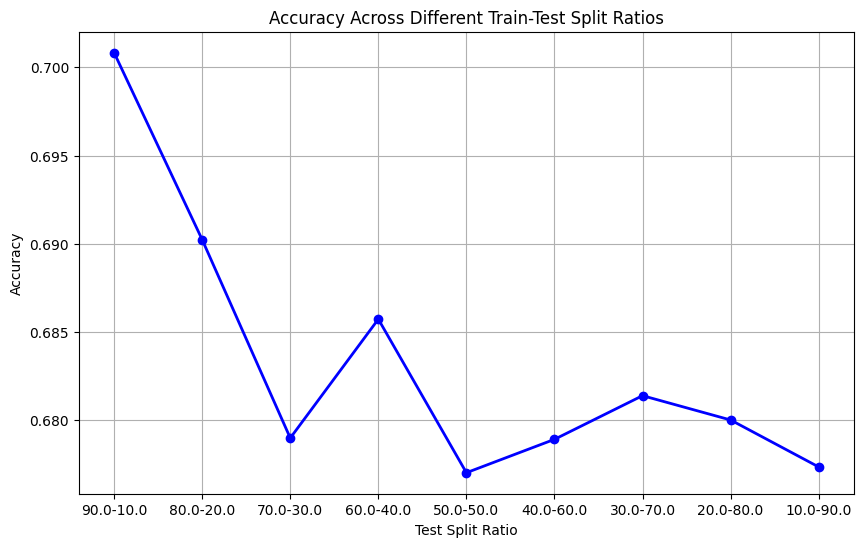

In [ ]:
# Store the accuracy for each split ratio
accuracies = []
splits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Loop through each test split ratio
for test_split_ratio in splits:
    X_train, X_test, y_train, y_test = train_test_split(ml_data.drop(columns="is_recid"), ml_data["is_recid"], test_size=test_split_ratio, random_state=2)

    # Instantiate and fit the logistic regression model
    logreg = LogisticRegression(random_state=16, max_iter=10000)
    logreg.fit(X_train, y_train)

    # Make predictions
    y_test_predict = logreg.predict(X_test)

    # Calculate the accuracy
    accuracy = metrics.accuracy_score(y_test, y_test_predict)

    # Append the accuracy value to the list
    accuracies.append(accuracy)

# Plot the accuracies across different split ratios
plt.figure(figsize=(10,6))
plt.plot(splits, accuracies, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
plt.title('Accuracy Across Different Train-Test Split Ratios')
plt.xlabel('Test Split Ratio')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(splits, [f'{(1 - ratio) * 100:.1f}-{ratio * 100:.1f}' for ratio in splits])
plt.show()


In [ ]:
sex_groups = ['Female', 'Male']
for group in sex_groups:
    group_data = ml_data[ml_data[f"sex_{group}"] == 1]  #group data based on gender
    X_group = group_data.drop(columns="is_recid")
    y_group = group_data["is_recid"]

    y_group_pred = logreg.predict(X_group)
    print(f"Performance for {group}:")
    print(classification_report(y_group, y_group_pred))

Performance for Female:
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       865
           1       0.66      0.46      0.54       530

    accuracy                           0.70      1395
   macro avg       0.69      0.66      0.66      1395
weighted avg       0.70      0.70      0.69      1395

Performance for Male:
              precision    recall  f1-score   support

           0       0.65      0.74      0.69      2878
           1       0.70      0.61      0.65      2941

    accuracy                           0.67      5819
   macro avg       0.68      0.67      0.67      5819
weighted avg       0.68      0.67      0.67      5819



In [ ]:
# List of races you want to evaluate (based on the dataset columns)
race_groups = ['African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other']

# Iterate through each race group to evaluate performance
for group in race_groups:
    # Group the data based on the race
    group_data = ml_data[ml_data[f"race_{group}"] == 1]  # Replace spaces with underscores in column names
    X_group = group_data.drop(columns="is_recid")
    y_group = group_data["is_recid"]

    # Predict using the trained logistic regression model
    y_group_pred = logreg.predict(X_group)

    # Print the performance for the group
    print(f"Performance for {group}:")
    print(classification_report(y_group, y_group_pred))


Performance for African-American:
              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1660
           1       0.73      0.65      0.69      2036

    accuracy                           0.68      3696
   macro avg       0.68      0.68      0.68      3696
weighted avg       0.68      0.68      0.68      3696

Performance for Asian:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        21
           1       1.00      0.36      0.53        11

    accuracy                           0.78        32
   macro avg       0.88      0.68      0.70        32
weighted avg       0.84      0.78      0.75        32

Performance for Caucasian:
              precision    recall  f1-score   support

           0       0.69      0.80      0.74      1429
           1       0.65      0.51      0.57      1025

    accuracy                           0.68      2454
   macro avg       0.67      0.65      0.66 

#De-Biasing


In [ ]:
ml_data.head()

,sex_Female,sex_Male,age_cat_25 - 45,age_cat_Greater than 45,age_cat_Less than 25,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,is_recid
0,False,True,False,True,False,False,False,False,False,False,True,69,0,1,0,0,0,0
1,False,True,True,False,False,True,False,False,False,False,False,34,0,3,0,0,0,1
2,False,True,False,False,True,True,False,False,False,False,False,24,0,4,0,1,4,1
3,False,True,False,False,True,True,False,False,False,False,False,23,0,8,1,0,1,0
4,False,True,True,False,False,False,False,False,False,False,True,43,0,1,0,0,2,0


In [ ]:
de_bias_data = ml_data.drop(columns=["sex_Female","sex_Male","age_cat_25 - 45","age_cat_Greater than 45", "age_cat_Less than 25","race_African-American","race_Asian","race_Caucasian","race_Hispanic","race_Native American","race_Other","age"])

In [ ]:
de_bias_data.head()

,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,is_recid
0,0,1,0,0,0,0
1,0,3,0,0,0,1
2,0,4,0,1,4,1
3,0,8,1,0,1,0
4,0,1,0,0,2,0


Train-Test split ratio: 90.0% - 10.0%
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       369
           1       0.71      0.56      0.63       353

    accuracy                           0.67       722
   macro avg       0.68      0.67      0.67       722
weighted avg       0.68      0.67      0.67       722

AUC-ROC: 0.7159346522643696

Cross-validated AUC-ROC scores: [0.73178656 0.70933642 0.73390659 0.72879377 0.7396112 ] 

Mean CV ROC-AUC: 0.7286869093399188
Train-Test split ratio: 80.0% - 20.0%
              precision    recall  f1-score   support

           0       0.67      0.78      0.72       754
           1       0.71      0.58      0.64       689

    accuracy                           0.69      1443
   macro avg       0.69      0.68      0.68      1443
weighted avg       0.69      0.69      0.68      1443

AUC-ROC: 0.7279434693728274

Cross-validated AUC-ROC scores: [0.70196586 0.73750632 0.72321257 0.72926692 0.745497

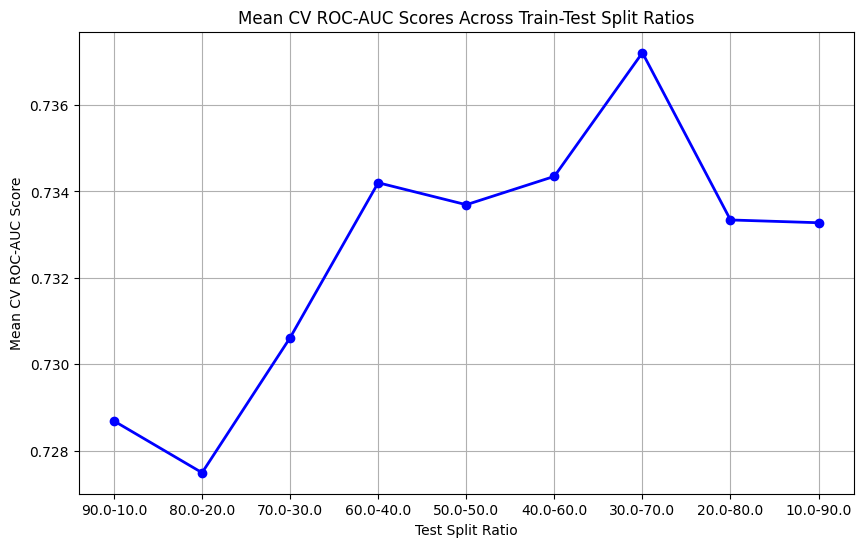

In [ ]:
# Define the split ratios
splits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Initialize an empty list to store the mean CV ROC-AUC scores
mean_roc_auc_scores = []

# Loop through each split ratio
for test_split_ratio in splits:
    X_train, X_test, y_train, y_test = train_test_split(
        de_bias_data.drop(columns="is_recid"),
        de_bias_data["is_recid"],
        test_size=test_split_ratio,
        random_state=123
    )

    # Instantiate the model
    logreg = LogisticRegression(random_state=16, max_iter=10000)

    # Fit the model
    logreg.fit(X_train, y_train)

    # Make predictions
    y_test_predict = logreg.predict(X_test)

    # Print classification report and AUC-ROC
    print(f"Train-Test split ratio: {(1-test_split_ratio)*100:.1f}% - {test_split_ratio*100:.1f}%")
    print(metrics.classification_report(y_test, y_test_predict))
    print("AUC-ROC:", metrics.roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]))

    # Perform cross-validation and compute mean CV ROC-AUC score
    scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='roc_auc')
    print("\nCross-validated AUC-ROC scores:", scores, "\n")
    print("Mean CV ROC-AUC:", scores.mean())

    # Append the mean ROC-AUC score to the list
    mean_roc_auc_scores.append(scores.mean())

# Plot the mean CV ROC-AUC scores across split ratios
plt.figure(figsize=(10, 6))
plt.plot(splits, mean_roc_auc_scores, marker='o', linestyle='-', color='b', linewidth=2, markersize=6)
plt.title('Mean CV ROC-AUC Scores Across Train-Test Split Ratios')
plt.xlabel('Test Split Ratio')
plt.ylabel('Mean CV ROC-AUC Score')
plt.grid(True)
plt.xticks(splits, [f'{(1 - ratio) * 100:.1f}-{ratio * 100:.1f}' for ratio in splits])
plt.show()


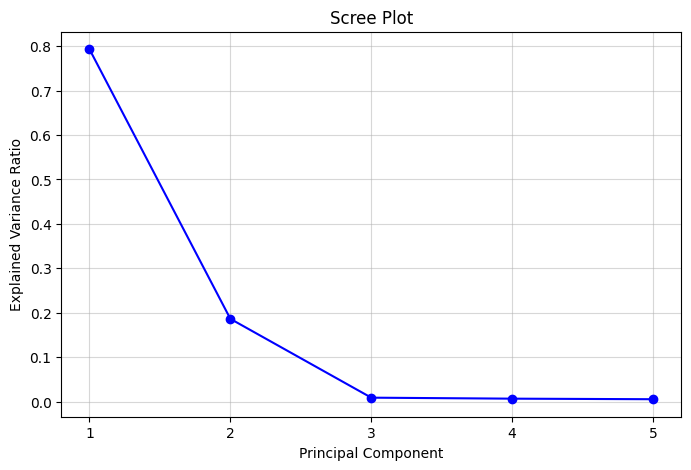


Cummulative Variance of each PC: - [0.79315859 0.97936446 0.98815494 0.99470927 1.        ]


In [ ]:
X = de_bias_data.drop(columns='is_recid') #features
pca = PCA()
X_pca = pca.fit_transform(X)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

#scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', color='b')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))  # Ensure PC indices are shown
plt.grid(alpha=0.5)
plt.show()

cumulative_variance = pca.explained_variance_ratio_.cumsum()
print("\nCummulative Variance of each PC: -",cumulative_variance)

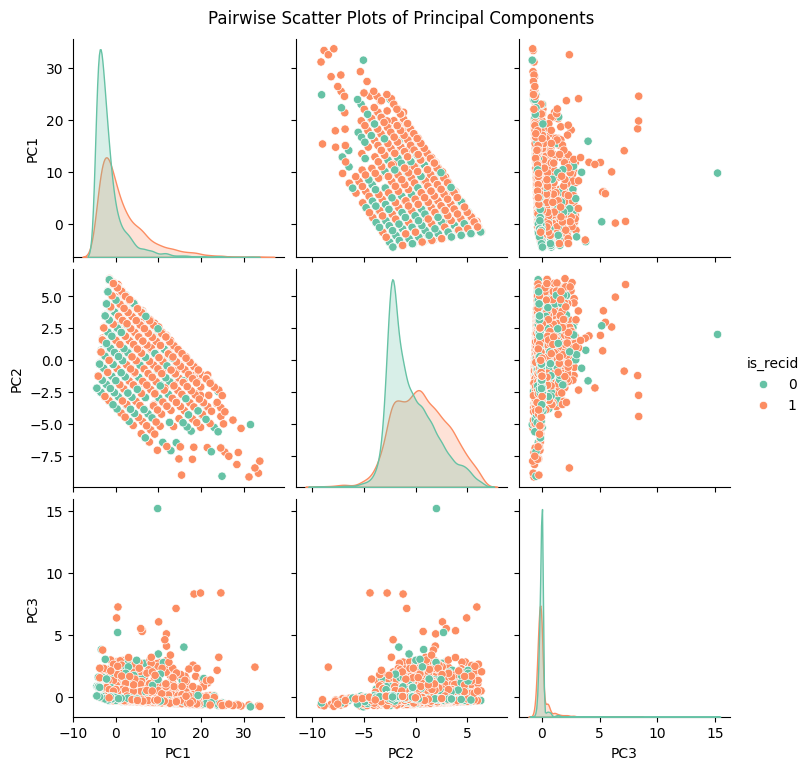

In [ ]:
X = de_bias_data.drop(columns='is_recid')  # Features
y = de_bias_data['is_recid']  # Labels

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

#PCA dataframe (PCA features table)
data_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(3)])
data_pca['is_recid'] = y  # Add the label column back
sns.pairplot(data_pca, vars=["PC1", "PC2", "PC3"], hue="is_recid", palette="Set2")
plt.suptitle("Pairwise Scatter Plots of Principal Components", y=1.02)
plt.show()

Train-Test split ratio: 90.0% - 10.0%
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       369
           1       0.71      0.56      0.63       353

    accuracy                           0.67       722
   macro avg       0.68      0.67      0.67       722
weighted avg       0.68      0.67      0.67       722

AUC-ROC: 0.715950006525561

Cross-validated AUC-ROC scores: [0.73234687 0.70931268 0.73391611 0.72781166 0.73903811] 

Mean CV ROC-AUC: 0.7284850841620879
Train-Test split ratio: 80.0% - 20.0%
              precision    recall  f1-score   support

           0       0.67      0.78      0.72       754
           1       0.71      0.58      0.64       689

    accuracy                           0.68      1443
   macro avg       0.69      0.68      0.68      1443
weighted avg       0.69      0.68      0.68      1443

AUC-ROC: 0.7279646433342445

Cross-validated AUC-ROC scores: [0.702152   0.73830634 0.72243359 0.7282744  0.7445440

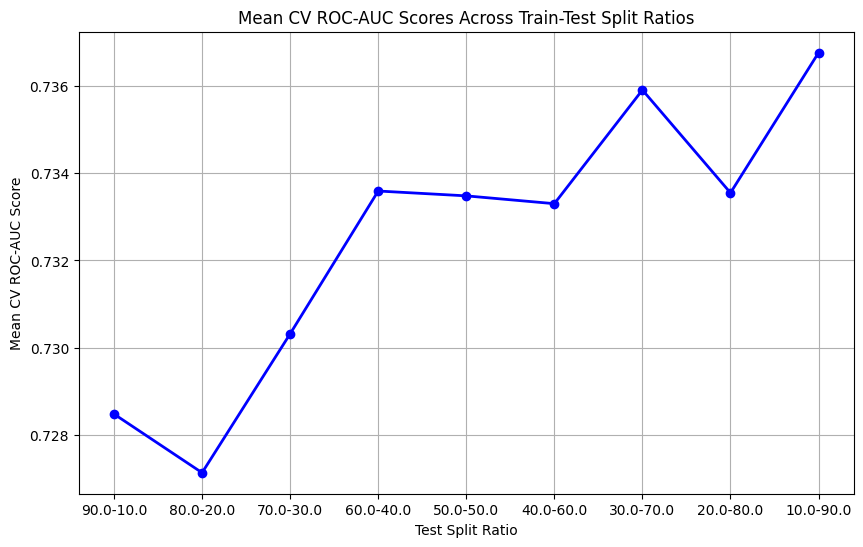

In [ ]:
# Define the split ratios
splits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Initialize an empty list to store the mean CV ROC-AUC scores
mean_roc_auc_scores = []

# Loop through each split ratio
for test_split_ratio in splits:
    X_train, X_test, y_train, y_test = train_test_split(
        data_pca.drop(columns="is_recid"),
        data_pca["is_recid"],
        test_size=test_split_ratio,
        random_state=123
    )

    # Instantiate the model
    logreg = LogisticRegression(random_state=16, max_iter=10000)

    # Fit the model
    logreg.fit(X_train, y_train)

    # Make predictions
    y_test_predict = logreg.predict(X_test)

    # Print classification report and AUC-ROC
    print(f"Train-Test split ratio: {(1-test_split_ratio)*100:.1f}% - {test_split_ratio*100:.1f}%")
    print(metrics.classification_report(y_test, y_test_predict))
    print("AUC-ROC:", metrics.roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]))

    # Perform cross-validation and compute mean CV ROC-AUC score
    scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='roc_auc')
    print("\nCross-validated AUC-ROC scores:", scores, "\n")
    print("Mean CV ROC-AUC:", scores.mean())

    # Append the mean ROC-AUC score to the list
    mean_roc_auc_scores.append(scores.mean())

# Plot the mean CV ROC-AUC scores across split ratios
plt.figure(figsize=(10, 6))
plt.plot(splits, mean_roc_auc_scores, marker='o', linestyle='-', color='b', linewidth=2, markersize=6)
plt.title('Mean CV ROC-AUC Scores Across Train-Test Split Ratios')
plt.xlabel('Test Split Ratio')
plt.ylabel('Mean CV ROC-AUC Score')
plt.grid(True)
plt.xticks(splits, [f'{(1 - ratio) * 100:.1f}-{ratio * 100:.1f}' for ratio in splits])
plt.show()
